# SST

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import classification_report

In [4]:
sst_train = pd.read_csv('data/ids-sst-train.csv', sep='\t', index_col=False)

In [5]:
100*sst_train['sentiment'].value_counts() / len(sst_train)

3    27.176966
1    25.959738
2    19.007491
4    15.074906
0    12.780899
Name: sentiment, dtype: float64

In [7]:
sst_val = pd.read_csv('data/ids-sst-dev.csv', sep='\t', index_col=False)

In [8]:
100*sst_val['sentiment'].value_counts() / len(sst_val)

1    26.248865
3    25.340599
2    20.799273
4    14.986376
0    12.624886
Name: sentiment, dtype: float64

Takeaways:
 - The outer sentiment classes are least frequent. Class 0 occurs around 12.7% of the time, class 4 occurs around 15.0% of the time
 - The middle classes, especially class 1 and 3, are most frequent. Hypothetically, these classes are most difficult to predict, as they are somewhat negative and somewhat positive (no extremely clear sentiment connotation in the text).

In [9]:
sst_val_pred = pd.read_csv('predictions/sst-dev-output.csv')

In [10]:
sst_val_pred.iloc[0]

id \t Predicted_Sentiment     4
Name: a7d575c9ed86ea9633660c67e , dtype: int64

In [11]:
sst_val.iloc[0,2]

" It 's a lovely film with lovely performances by Buy and Accorsi ."

Difficult to handle middle cases. See above example; lovely performance, lovely film. We predict most positive sentiment (4), but label is 3. This makes it difficult. Our predictions are balanced, but middle cases are very difficult (see e.g., recall group with label 2).

In [12]:
y_pred = sst_val_pred['id \t Predicted_Sentiment '].to_numpy()
y = sst_val['sentiment'].to_numpy()

In [13]:
y == y_pred

array([False, False,  True, ...,  True, False,  True])

In [14]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.27      0.36       139
           1       0.51      0.69      0.58       289
           2       0.38      0.20      0.26       229
           3       0.48      0.79      0.60       279
           4       0.74      0.30      0.43       165

    accuracy                           0.50      1101
   macro avg       0.53      0.45      0.45      1101
weighted avg       0.52      0.50      0.47      1101



In [15]:
for i in range(len(sst_val)):
    if sst_val.iloc[i, 3] == 3:
        print(sst_val.iloc[i,2])
        break

 It 's a lovely film with lovely performances by Buy and Accorsi .


# Sentence Pairs

Comment on small data STS, huge data Paraphrase.

 - Fractions of labels for Paraphrase
 - Fractions of labels for STS
 - Distribution of STS
 - This distribution does not necessarily align with the distribution that will arise due to cosine similarity. Makes it difficult
 - But a lot of similarity between paraphrase and STS. Give example sentences that are similar. Definitely harnessing power of using both alongside each other or using all paraphrase data at once.

## Paraphrase Data

In [17]:
para_train = pd.read_csv('data/quora-train.csv', sep='\t')

In [18]:
100*para_train['is_duplicate'].value_counts() / len(para_train)

0.0    63.053863
1.0    36.940483
Name: is_duplicate, dtype: float64

In [20]:
para_dev = pd.read_csv('data/quora-dev.csv', sep='\t')

In [21]:
100*para_dev['is_duplicate'].value_counts() / len(para_dev)

0.0    62.466607
1.0    37.523499
Name: is_duplicate, dtype: float64

Train and dev sets are nicely balanced, around 63% of sentence pairs belong to non-paraphrases. 

In [22]:
para_pred_dev = pd.read_csv('predictions/para-dev-output.csv')

In [23]:
para_pred_dev.columns = ['pred']

In [24]:
100*para_pred_dev.value_counts() / len(para_pred_dev)

pred
0.0     60.909361
1.0     39.090639
dtype: float64

Prediction counts are also nicely balanced.

In [25]:
for i in range(len(para_dev)):
    id_ = para_dev.iloc[i,1]
    if (id_ + ' ') not in para_pred_dev.index:
        print(i)

2575
14220


In [26]:
para_dev = para_dev.drop([2575, 14220])

In [27]:
y_pred = para_pred_dev['pred'].to_numpy()
y = para_dev['is_duplicate'].to_numpy()

In [28]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12627
         1.0       0.81      0.84      0.83      7585

    accuracy                           0.87     20212
   macro avg       0.86      0.86      0.86     20212
weighted avg       0.87      0.87      0.87     20212



Our method finds it slightly more difficult to predict true paraphrases. It does well on the majority class (i.e., non-paraphrase texts), but achieves lower precision and recall on the paraphrases.

## STS Data

In [29]:
sts_train = pd.read_csv('data/sts-train.csv', sep='\t')

In [30]:
sts_dev = pd.read_csv('data/sts-dev.csv', sep='\t')

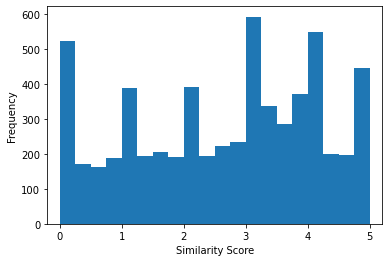

In [64]:
plt.figure(0)
plt.hist(sts_train['similarity'], bins=20)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.xlim((-0.2,5.2))
plt.savefig('true_sts.png')

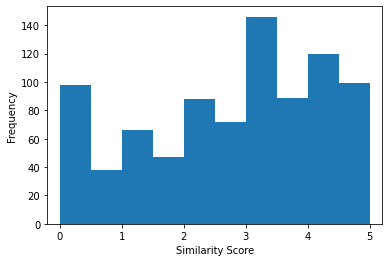

In [63]:
plt.figure(0)
plt.hist(sts_dev['similarity'], bins=10)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.xlim((-0.2,5.2))
plt.savefig('true_sts.png')

In [35]:
np.mean(sts_train['similarity'])

2.613143114685166

In [36]:
np.mean(sts_dev['similarity'])

2.7231399510750607

In [37]:
np.std(sts_train['similarity'])

1.4876745541785574

In [38]:
np.std(sts_dev['similarity'])

1.4754419855272725

The train and dev set seem to be nicely balanced, i.e., their distributions look really alike. However, it is clear from the histograms that the distributions are a bit ill-defined. That is, the distributions seem to be multimodal around the whole integer values 0 to 5. This may be an issue of data labeling, e.g., there is some bias towards labeling two sentences' similarity score using a whole number. This can obviously be difficult for a model to predict. Ideally, especially using some kind of cosine similarity score, the distribution would be more smooth or, as we use MSE loss for training, close to Gaussian. This is definitely not the case, which, in addition to the low number of data points, makes this STS task difficult.

In [40]:
sts_pred_dev = pd.read_csv('predictions/sts-dev-output.csv')

In [41]:
sts_pred_dev.columns = ['pred']

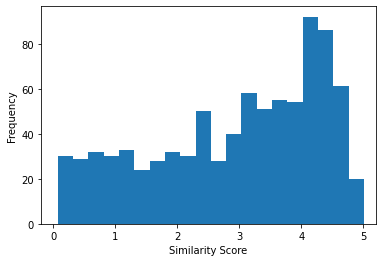

In [62]:
plt.hist(sts_pred_dev['pred']*5.4, bins=20)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.xlim((-0.2, 5.2))
plt.savefig('pred_sts.png')

Clear to see that predicted distribution is totally off wrt what the actual distribution is. It is heavily skewed towards large positive numbers. This makes for a poor fit with the actual data. Correlation may be good, but the actual values do not reflect the true distribution. This figure also explains the phenomenon that scaling labels to the -1 to 1 range does not lead to good results; the output is almost never lower than 0, which makes a -1 to 1 range extremely poor.

## Combined Para and STS

In [136]:
print("The STS dataset has {} entries".format(len(sts_train)))
print("The Paraphrase dataset has {} entries".format(len(para_train)))

The STS dataset has 6040 entries
The Paraphrase dataset has 141506 entries


We want to make use of the paraphrase data and, if possible, use it to better predict STS. Why would this work? Well, both datasets consist of sentence pairs and aim at evaluating the similarity of these sentences. This similarity in tasks, although not 1-on-1 related, could mean that using paraphrase data could boost STS performance. 

In [137]:
sts_train

,Unnamed: 0,id,sentence1,sentence2,similarity
0,8615,6d0ec4e8a34ac432e1c1699a0,13 killed in Afgan terror attack,6 killed in Afghan capital mosque attack,2.00
1,7087,9aaabdce8cfff4c060b6f525c,China to resume US investment talks,China and Taiwan hold historic talks,0.80
2,8201,a70c8ad3f82ac2967f78fe617,But in the first 30 seconds after Young entere...,"But in the first 30 seconds of the bout, famil...",4.20
3,7821,a89ed469c8f2f81313d190e66,A yellow vested person is doing road work.,A person is doing very well on their skateboard.,0.20
4,201,9ee4d44188c33f4e7d899e690,Someone is slicing tortila's.,Someone is riding a horse.,0.00
...,...,...,...,...,...
6035,3407,02aec281e8042cb6ac5234d0e,TVT Records sought $360 million in punitive da...,The damages included $24 million in compensato...,1.25
6036,705,428993345175717b8e038007c,The woman is thinly slicing a cucumber.,The woman is slicing a tomato.,1.20
6037,510,627aec89c90cbc047a6000315,A girl is playing a guitar.,A man is playing a guitar.,2.80
6038,6349,71e5c54b6506f84a911731c93,A basketball player makes the 5th rebound of t...,A tennis player in the middle of a game.,1.40


In [148]:
for i in range(len(sts_train)):
    if 'right and wrong?' in sts_train['sentence1'].iloc[i]:
        print(sts_train.iloc[i,:])

Unnamed: 0                                             2366
id                                ecac2f49e4d3afd484df62921
sentence1           How do you know what's right and wrong?
sentence2     How do you know which story is the right one?
similarity                                              2.2
Name: 443, dtype: object


In [146]:
for i in range(len(para_train)):
    if 'right and wrong' in para_train.iloc[i, 2]:
        print(para_train.iloc[i,:])

Unnamed: 0                                         27066
id                             9fd3e0aa9ed2d3d520d2b84d3
sentence1       How are right and wrong defined? And why
sentence2               What is right and what is wrong?
is_duplicate                                         1.0
Name: 19750, dtype: object


TypeError: argument of type 'float' is not iterable

There's definitely a lot of similarity in the two data sets and this makes for our hypothesis that using the paraphrase data can be super helpful for the STS task. In addition, paraphrase data contains mostly questions (Quora questions), which leads to pretty orthogonal text to SST data (mostly things like reviews, more emotive). This leads us to hypothesize that using more paraphrase data will not necessarily be harmful for SST predictions.

Also good motive for using separate optimizer steps instead of one big one;
 - You take more steps, which might be beneficial
 - The data sets are pretty orthogonal (expected), which makes it not harmful to set separate steps
 - The losses of the three data sets are not necessarily on the same scale. Doing separate steps may be desirable to keep the influence of the three losses separable. This issue of combining losses on different scales occurs everywhere and is difficult, e.g., think about Douwe Kiela's discussion on multimodal models.